In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src.utils.general import get_db_conn

In [3]:
creds_folder = '../conf/local/'
fpath = os.path.join(creds_folder, 'credentials.yaml')
db_con = get_db_conn(fpath)

#### Bills per year

In [47]:
q = """
    select 
        extract(year from introduced_date)::int as year,
        count(*) as num_bills
    from clean.bills
    group by extract(year from introduced_date)
    --having extract(year from introduced_date) >=2000
"""

In [48]:
yearly_bills = pd.read_sql(q, db_con)
msk = (yearly_bills['year'] >=2009) & (yearly_bills['year'] <=2019)

Text(0.5, 1.0, 'Number of bills in the dataset for each year')

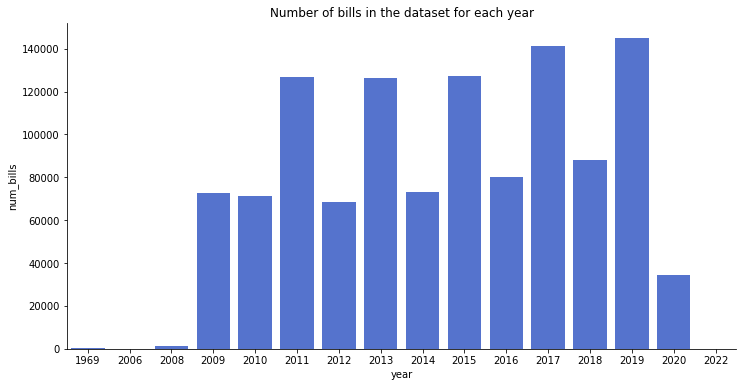

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=yearly_bills, x='year', y='num_bills', color='royalblue', ax=ax)
# plt.axvline(x=2009)
sns.despine(left=False, bottom=False)
ax.set_title('Number of bills in the dataset for each year')
# fig.savefig('deep_dive_figs/bills_per_year.png', bbox_inches='tight')

#### Bills by state

In [41]:
q = """
    select 
        max(state_abbreviation) as state,
        count(*) as num_bills
    from clean.bills join clean.sessions using(session_id)
        join catalogs.states using(state_id)
    group by state
    order by state
"""

In [42]:
states_bills = pd.read_sql(q, db_con)

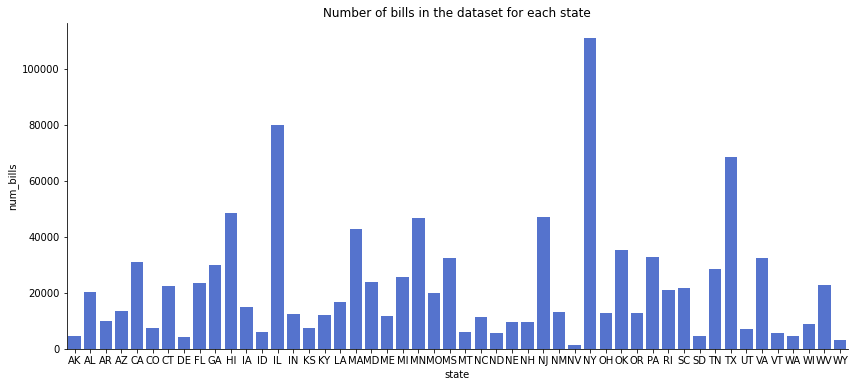

In [44]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=states_bills, x='state', y='num_bills', color='royalblue', ax=ax)
# plt.axvline(x=2009)
sns.despine(left=False, bottom=False)
ax.set_title('Number of bills in the dataset for each state')
fig.savefig('deep_dive_figs/bills_per_state.png', bbox_inches='tight')

### Bill passing success rates

In [53]:
q = """
   with state_bills as (
        select 
            bill_id,
            state_id,
            state,
            state_abbreviation,
            introduced_date
        from clean.bills join clean.sessions using (session_id)
            join catalogs.states using (state_id)
        --where state='{}' and not special
    ),
    pass_details as (
        with conclusions as (
            select 
                bill_id,
                max(case when (event=4 or event=5 or event=6) then progress_date end) as conclude_date
            from clean.bill_progress group by bill_id
        )
        select 
            bill_id,
            max((case when (progress_date=conclude_date and event=4) then progress_date end)) as passed_date,
            max((case when (progress_date=conclude_date and event=4) then true end)::int) as passed
        from conclusions left join clean.bill_progress using (bill_id)
        group by bill_id
    )
    select 
        state_abbreviation as state,
        count(distinct bill_id) as total_bills,
        sum(passed) as num_bills_passed,
        sum(passed)::float/count(distinct bill_id) as passed_fraction,
        avg(passed_date::DATE - introduced_date::DATE) as days_to_pass
    from state_bills join pass_details using (bill_id)
    group by state_abbreviation
"""

In [54]:
passage_stats_bills = pd.read_sql(q, db_con)

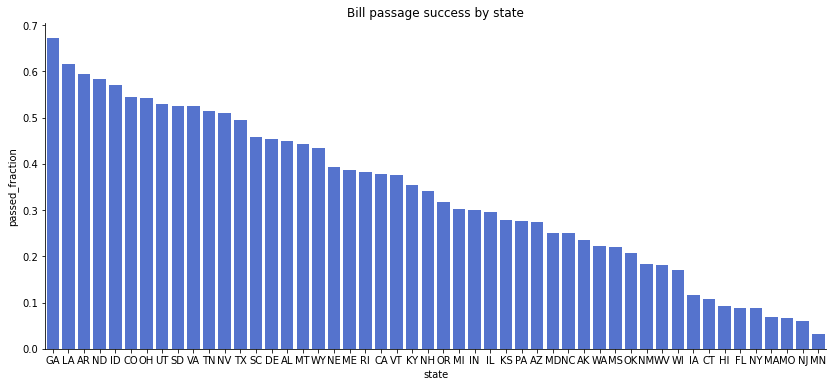

In [56]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=passage_stats_bills.sort_values('passed_fraction', ascending=False), x='state', y='passed_fraction', color='royalblue', ax=ax)
sns.despine(left=False, bottom=False)
ax.set_title('Bill passage success by state')
fig.savefig('deep_dive_figs/bills_passage_success.png', bbox_inches='tight')

In [65]:
# fig, ax = plt.subplots(figsize=(14, 6))
# sns.barplot(data=passage_stats_bills.sort_values('days_to_pass', ascending=True), x='state', y='days_to_pass', color='royalblue', ax=ax)
# sns.despine(left=False, bottom=False)
# ax.set_title('Bill passage success by state')
# # fig.savefig('deep_dive_figs/time_to_pass.png', bbox_inches='tight')

#### Median time it takes to pass a bill by state

In [86]:
q = """
    with state_bills as (
        select 
            bill_id,
            state_id,
            state,
            state_abbreviation,
            introduced_date
        from clean.bills join clean.sessions using (session_id)
            join catalogs.states using (state_id)
        --where state='{}' and not special
    ),
    pass_details as (
        with conclusions as (
            select 
                bill_id,
                max(case when (event=4 or event=5 or event=6) then progress_date end) as conclude_date
            from clean.bill_progress group by bill_id
        )
        select 
            bill_id,
            max(conclude_date) as decision_date,
            max((case when (progress_date=conclude_date and event=4) then progress_date end)) as passed_date,
            max((case when (progress_date=conclude_date and event=5) then progress_date end)) as vetoed_date,
            max((case when (progress_date=conclude_date and event=6) then progress_date end)) as failed_date,
            max((case when (progress_date=conclude_date and event=4) then true else false end)::int) as passed,
            max((case when (progress_date=conclude_date and event=5) then true else false end)::int) as vetoed,
            max((case when (progress_date=conclude_date and event=6) then true else false end)::int) as failed
        from conclusions left join clean.bill_progress using (bill_id)
        group by bill_id
    )
    select 
        bill_id,
        state_abbreviation as state,
        passed,
        vetoed,
        failed,
        (decision_date::DATE - introduced_date::DATE)::int as days_to_decision,
        (passed_date::DATE - introduced_date::DATE)::int as days_to_pass,
        (failed_date::DATE - introduced_date::DATE)::int as days_to_fail,
        (vetoed_date::DATE - introduced_date::DATE)::int as days_to_vetoe
    from state_bills join pass_details using (bill_id)
    --where passed=1
"""

In [87]:
time_to_pass = pd.read_sql(q, db_con)

Text(0.5, 1.0, 'Median time to get a bill passed')

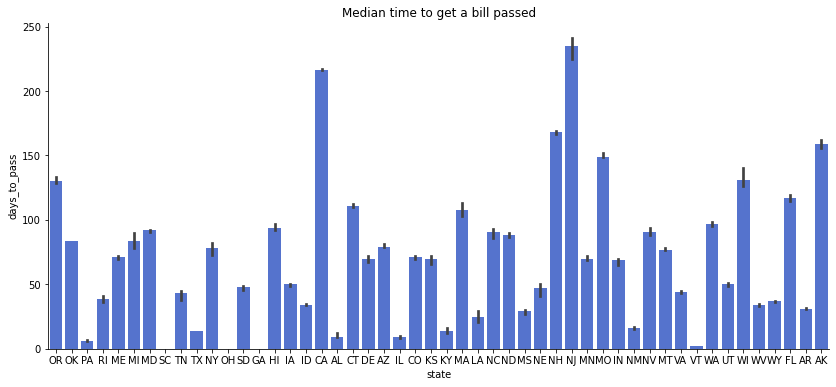

In [74]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=time_to_pass, x='state', y='days_to_pass', color='royalblue', ax=ax, estimator=np.median)
sns.despine(left=False, bottom=False)
ax.set_title('Median time to get a bill passed')
# fig.savefig('deep_dive_figs/time_to_pass_median.png', bbox_inches='tight')

##### subplot

Text(0.5, 1.0, 'Median time to get a bill passed')

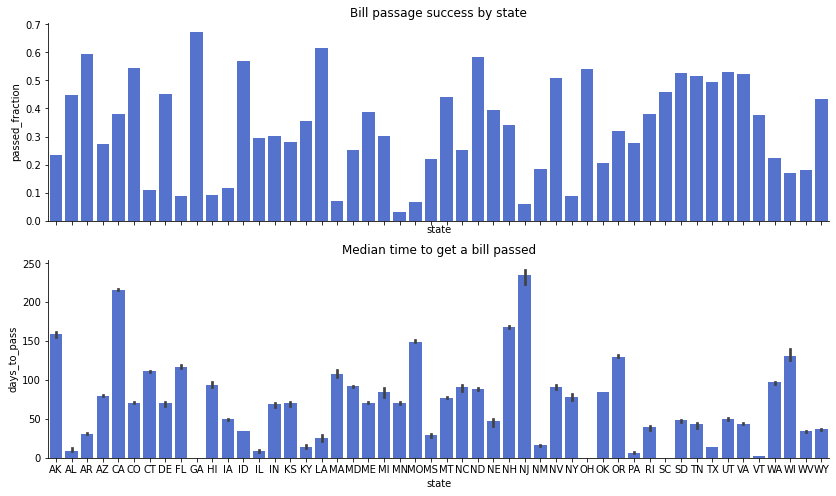

In [94]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

sns.barplot(data=passage_stats_bills.sort_values('state'), x='state', y='passed_fraction', color='royalblue', ax=axes[0])
sns.despine(left=False, bottom=False)
axes[0].set_title('Bill passage success by state')

sns.barplot(data=time_to_pass.sort_values('state'), x='state', y='days_to_pass', color='royalblue', ax=axes[1], estimator=np.median)
sns.despine(left=False, bottom=False)
axes[1].set_title('Median time to get a bill passed')
fig.savefig('deep_dive_figs/bill_passage_success_time.png', bbox_inches='tight')

In [96]:
fig.savefig('deep_dive_figs/bill_passage_success_time2.png', bbox_inches='tight', dpi=300)

In [89]:
# fig, ax = plt.subplots(figsize=(14, 6))
# sns.barplot(data=time_to_pass, x='state', y='days_to_decision', color='royalblue', ax=ax, estimator=np.median, hue='passed')
# sns.despine(left=False, bottom=False)
# ax.set_title('Median time for a bill to fail')